# Principal Component Analysis (PCA) - Example

Reducing the number of input variables for a predictive model is referred to as dimensionality reduction. Fewer input variables can result in a simpler predictive model that may have better performance when making predictions on new data. Perhaps the most popular technique for dimensionality reduction in machine learning is Principal Component Analysis, or PCA for short.

If your data is represented using rows and columns, such as in a spreadsheet, then the input variables are the columns that are fed as input to a model to predict the target variable. Input variables are also called features. We can consider the columns of data representing dimensions on an n-dimensional feature space and the rows of data as points in that space. This is a useful geometric interpretation of a dataset. Having a large number of dimensions in the feature space can mean that the volume of that space is very large, and in turn, the points that we have in that space (rows of data) often represent a small and non-representative sample. This can dramatically impact the performance of machine learning algorithms fit on data with many input features, generally referred to as the “curse of dimensionality.”

A popular approach to dimensionality reduction is to use techniques from the field of linear algebra. This is often called “feature projection” and the algorithms used are referred to as “projection methods.” Projection methods seek to reduce the number of dimensions in the feature space whilst also preserving the most important structure or relationships between the variables observed in the data. 

In essence, the original features no longer exist and new features are constructed from the available data that are not directly comparable to the original data, e.g. don’t have column names. Any new data that is fed to the model in the future when making predictions, such as test dataset and new datasets, must also be projected using the same technique.

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

## Load data

First, we can use the make_classification() function to create a synthetic binary classification problem with 1,000 examples and 20 input features, 15 inputs of which are meaningful.

We will use a Pipeline where the first step performs the PCA transform and selects the 10 most important dimensions or components, then fits a logistic regression model on these features. We don’t need to normalize the variables on this dataset, as all variables have the same scale by design.

`steps = [('s', StandardScaler()), ('pca', PCA()), ('m', LogisticRegression())]` 

The pipeline will be evaluated using repeated stratified cross-validation with three repeats and 10 folds per repeat. Performance is presented as the mean classification accuracy.

In [2]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

In [3]:
# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


## Baseline Model

In [4]:
# define the model
model = LogisticRegression()

In [5]:
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [6]:
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.865 (0.027)


## Model with PCA

In [7]:
# define the pipeline
steps = [('pca', PCA(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)

In [8]:
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [9]:
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.816 (0.034)


How do we know that reducing 20 dimensions of input down to 10 is good or the best we can do?

We don’t; 10 was an arbitrary choice.

A better approach is to evaluate the same transform and model with different numbers of input features and choose the number of features (amount of dimensionality reduction) that results in the best average performance.

In [10]:
# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

In [11]:
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,21):
		steps = [('pca', PCA(n_components=i)), ('m', LogisticRegression())]
		models[str(i)] = Pipeline(steps=steps)
	return models

In [12]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [13]:
# define dataset
X, y = get_dataset()
print(X.shape, y.shape)

(1000, 20) (1000,)


In [14]:
# get the models to evaluate
models = get_models()

In [15]:
# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>1 0.542 (0.048)
>2 0.713 (0.048)
>3 0.720 (0.053)
>4 0.723 (0.051)
>5 0.725 (0.052)
>6 0.730 (0.046)
>7 0.805 (0.036)
>8 0.800 (0.037)
>9 0.814 (0.036)
>10 0.816 (0.034)
>11 0.819 (0.035)
>12 0.819 (0.038)
>13 0.819 (0.035)
>14 0.853 (0.029)
>15 0.865 (0.027)
>16 0.865 (0.027)
>17 0.865 (0.027)
>18 0.865 (0.027)
>19 0.865 (0.027)
>20 0.865 (0.027)


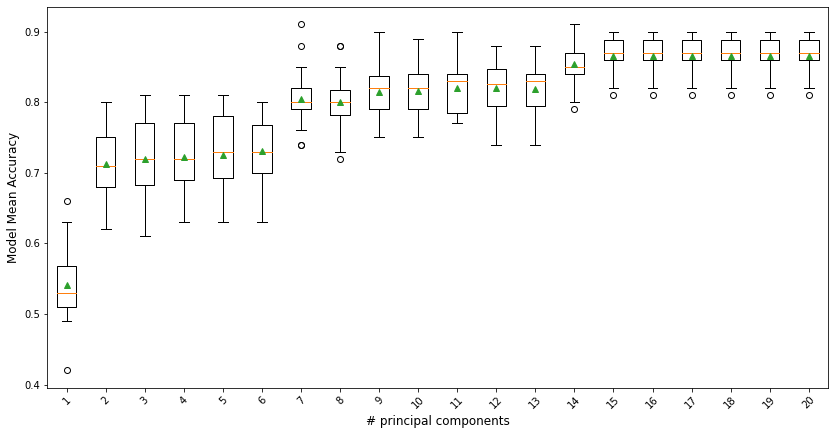

In [16]:
# plot model performance for comparison
plt.figure(figsize=(14,7))
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.xlabel("# principal components", fontsize=12)
plt.ylabel("Model Mean Accuracy", fontsize=12)
plt.show()

We see a general trend of increased performance as the number of dimensions is increased. On this dataset, the results suggest a trade-off in the number of dimensions vs. the classification accuracy of the model.

Interestingly, we don’t see any improvement beyond 15 components. This matches our definition of the problem where only the first 15 components contain information about the class and the remaining five are redundant.

A box and whisker plot is created for the distribution of accuracy scores for each configured number of dimensions. We can see the trend of increasing classification accuracy with the number of components, with a limit at 15.

We may choose to use a PCA transform and logistic regression model combination as our final model. This involves fitting the Pipeline on all available data and using the pipeline to make predictions on new data. Importantly, the same transform must be performed on this new data, which is handled automatically via the Pipeline.



In [17]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
print(X.shape, y.shape)

(1000, 20) (1000,)


In [18]:
# define the model
steps = [('pca', PCA(n_components=15)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)

In [19]:
# fit the model on the whole dataset
model.fit(X, y)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('m',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [20]:
# make a single prediction
row = [[0.2929949,-4.21223056,-1.288332,-2.17849815,-0.64527665,2.58097719,0.28422388,-7.1827928,-1.91211104,2.73729512,0.81395695,3.96973717,-2.66939799,3.34692332,4.19791821,0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808]]
yhat = model.predict(row)
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1


Running the example fits the Pipeline on all available data and makes a prediction on new data.

Here, the transform uses the 15 most important components from the PCA transform, as we found from testing above.

A new row of data with 20 columns is provided and is automatically transformed to 15 components and fed to the logistic regression model in order to predict the class label.